In [ ]:
import numpy as np 
from numpy import random
import matplotlib.pyplot as plt
import sklearn.datasets
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set up: d=10

Let $ \mathbf{S}^d = \{ w : ||w||_1 = 1 \} $. $X = [-1,1]^{d}$. 

We take $\pi_0$ to be the uniform distribution over $ \mathbf{S}^d $ and $f^{*} = σ(⟨w^{*},x⟩)$, where $σ$ is the ReLu activation function. 


We choose $w^{*}$ on the unit ball to be a vector of length d such that the $L^1$ norm of $w$ is 1. 




For a fixed $π$, we define 
$$ \mathcal{H}_\pi(X) := \{ ∫_{\mathbb{S}^{d}} a(w)(\langle w,x \rangle) d\pi (w) : ||f||_{\mathcal{H}_\pi} < ∞ \}
 $$ 



### Generating data $x$ and $w^*$

In [ ]:
np.random.seed(0)

In [ ]:
d = 10
n = 1000

In [ ]:
#Generating x-values. X is in [-1,1]^d 

X = np.random.uniform(-1,1, (1500,10))

In [ ]:
#choosing W* on the unit ball with ||W||=1 d-length 
w = np.random.uniform(-1,1, (d))
w_n = np.linalg.norm(w, ord=1, axis=0, keepdims=True)
w_star = (w / w_n)


In [ ]:
w_star.shape

(10,)

In [ ]:
  w = np.random.uniform(-1,1, (10, 2)) # w uniformly sampled from a unit sphere 
  w_norm = np.linalg.norm(w, ord=1, axis=1, keepdims=True)
  w.shape, w_norm.shape

((10, 2), (10, 1))

### Target function: $f^{*} = σ(⟨w^{*},x⟩)$

In [ ]:
#activation function 
def relu(x):
  return(np.maximum(0,x))

In [ ]:
#target function
y = relu(np.inner(w_star, X))
y.shape


(1500,)

##### Splitting data to X_train, X_test and X_val:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1 )

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((900, 10), (900,), (300, 10), (300,), (300, 10), (300,))

### Kernel Function

In [ ]:
#kernel from eq 3.5 
def k(x,y, num_samples=500): #independent of d 
    assert x.ndim == y.ndim == 2
    d = x.shape[1]
    assert y.shape[1] == d

    w = np.random.uniform(-1,1, (num_samples, d)) # w uniformly sampled from a unit sphere 
    w_norm = np.linalg.norm(w, ord=1, axis=1, keepdims=True)
    w1 = w / w_norm
    
    relu_1 = relu(np.inner(w1, x)) # (num_samples, n1)
    relu_2 = relu(np.inner(w1, y)) # (num_samples, n2)
    relu_1 = np.expand_dims(relu_1, 2)  # (num_samples, n1, 1)
    relu_2 = np.expand_dims(relu_2, 1)  # (num_samples, 1, n2)
    inner = relu_1 * relu_2  # (num_samples, n1, n2)
    return np.mean(inner, axis=0)  # (n1, n2)

In [ ]:
k(np.ones((1, 11)), np.ones((47, 11))).shape

(1, 47)

### Kernel Ridge Regression

The solution to the kernel ridge regression is given by

$$y^* = \mathbf{K}(x^*, \mathbf{x})(\mathbf{K}(\mathbf{x,x}) + λI_{N})^{-1} \mathbf{y} $$ 

In [ ]:
#KERNEL RIDGE REGRESSION 
def kernel_coefficients(x, y, penalty):
  assert x.ndim == 2
  n = x.shape[0]
  d = x.shape[1]
  assert y.ndim == 1
  assert y.shape[0] == n

  I = np.identity(n) #identity matrix 
  return np.linalg.solve(k(x,x) + penalty * I, y)

def kernel_model(x_test, x_samples, coeffs):
  assert x_test.ndim == x_samples.ndim == 2
  return np.inner(k(x_test, x_samples), coeffs) 

#### $λ = 0.1$ 

In [ ]:
c = kernel_coefficients(X_train, y_train, 0.1)
y_pred = kernel_model(X_train, X_train, c)

y_pred.shape

(900,)

In [ ]:
c.shape

(900,)

In [ ]:
k_MSE = mean_squared_error(y_train, y_pred)
k_MSE

0.0025217266962658377

#### $λ = 0 $ 

In [ ]:
c0 = kernel_coefficients(X_train, y_train, 0)
y_pred0 = kernel_model(X_train, X_train, c0)



In [ ]:
mean_squared_error(y_train, y_pred0)


9.570207052694133e+32

#### Grid Search for $λ$


In [ ]:
params = np.arange(0.01, 0.51, 0.01) 
params

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])

In [ ]:



d = {}
for c in params:
  c_vals = kernel_coefficients(X_val, y_val, c)
  #d[c] = c_vals
  temp = kernel_model(X_val, X_val, c_vals)
  d[c] = mean_squared_error(y_val, temp)
d


{0.01: 0.003126529705517963,
 0.02: 0.003024502862953232,
 0.03: 0.0031282065585062978,
 0.04: 0.00276904910170341,
 0.05: 0.002615744511853513,
 0.060000000000000005: 0.0021723999009329873,
 0.06999999999999999: 0.0030486688566272696,
 0.08: 0.0024081735829808173,
 0.09: 0.0032115943149804474,
 0.09999999999999999: 0.0033549096710227093,
 0.11: 0.0028707092642625536,
 0.12: 0.004663933465826055,
 0.13: 0.004101006687598561,
 0.14: 0.0035465163690505904,
 0.15000000000000002: 0.004059642617611828,
 0.16: 0.004143804153089309,
 0.17: 0.004914684422267097,
 0.18000000000000002: 0.004727495291333025,
 0.19: 0.0037412558403077806,
 0.2: 0.0046243430535183785,
 0.21000000000000002: 0.005835081235471734,
 0.22: 0.006446717101656579,
 0.23: 0.0052704228664279045,
 0.24000000000000002: 0.0045240829806241535,
 0.25: 0.004973885274148116,
 0.26: 0.007181550950627013,
 0.27: 0.0042271410600181625,
 0.28: 0.006653333262315176,
 0.29000000000000004: 0.006924643990870223,
 0.3: 0.00692991713212403,


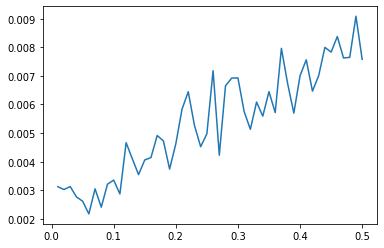

In [ ]:
plt.plot(list(d.keys()), list(d.values()))


We will look for $\lambda$ between 0.001 and 0.1 

In [ ]:
params2 = np.arange(0.001, 0.05, 0.001)
params2

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049])

In [ ]:

d = {}
for c in params2:
  c_vals = kernel_coefficients(X_val, y_val, c)
  #d[c] = c_vals
  temp = kernel_model(X_val, X_val, c_vals)
  d[c] = mean_squared_error(y_val, temp)
d;


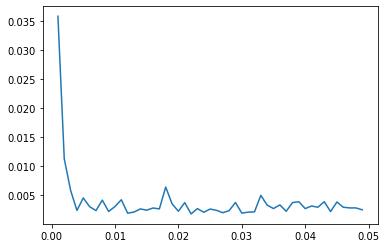

In [ ]:
plt.plot(list(d.keys()), list(d.values()))

#### Testing the model with $λ = 0.022$ 

In [ ]:
c_test = kernel_coefficients(X_test, y_test, 0.022)
y_pred_test = kernel_model(X_test, X_test, c_test)
mean_squared_error(y_test, y_pred_test)

0.0013868214288288601

In [ ]:
X_test.shape, X_train.shape, c_test.shape

((300, 10), (900, 10), (300,))

#### RKHS norm

In [ ]:
c_test.shape

(300,)

In [ ]:
c = kernel_coefficients(X_train, y_train, 0.001)

In [ ]:
kernel_matrix = k(X_train, X_train) 
kernel_matrix.shape , c.shape


((900, 900), (900,))

In [ ]:
Ct = kernel_matrix @ c


In [ ]:
kernel_rkhs = np.sqrt(np.inner(Ct, c)) #rkhs norm for kernels 
kernel_rkhs

19.5429815317075

# Two layer neural network

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras import initializers

In [ ]:
#model = keras.models.Sequential([
    #keras.layers.Dense(10, input_shape=(10,), activation="relu"), 
    #keras.layers.Dense(1, activation="linear") #output layer
#])

In [ ]:
opt = keras.optimizers.Adam()

In [ ]:
#model.compile(loss="MSE",
                     #optimizer=opt,
              #metrics="accuracy")

In [ ]:
#history = model.fit(X_train, y_train, batch_size=32, epochs =1000, validation_data = (X_val, y_val), verbose=0)

In [ ]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Loss vs. epochs')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['Training', 'Validation'], loc='upper right')
#plt.show()

#### Mean Squared Error 

In [ ]:
#pred_train= model.predict(X_train)
#print(mean_squared_error(y_train,pred_train))

#pred= model.predict(X_test)
#print(mean_squared_error(y_test,pred))

#### Path norm

$$ ||θ||_{\mathcal{P}} = ∑^{m}_{k=1} |{a_k}|||w_k||_1$$



In [ ]:
def norms(model): 
  """
  calculates the path norm and rkhs norm of a given neural network model 
  model - chosen NN model 
  """
  path_norm = []
  rkhs_norm = []
  # layer 1 kernel, shape should be (d,10)
  w_i = model.layers[0].kernel
  # converting tensor into np array 
  w_i = w_i.numpy()
  # layer 1 bias 
  b_i = model.layers[0].bias 
  # converting b_i into np array 
  b_i = b_i.numpy()
  # we want to append b_i to w_i across rows 
  # shape of w will be now (d+1,10)
  w = np.append(w_i, [b_i], axis=0)
  # we want to calculate the l1 norm down each column 
  # this is our w_k matrix
  w_norm = np.linalg.norm(w, ord=1, axis=0, keepdims=False)
  # layer 2 kernel, shape: (10,1)
  a = model.layers[1].kernel
  # converting tensor into np array 
  a = a.numpy()
  a = np.squeeze(a)
  # calculating the absolute value element wise
  a_norm = np.abs(a)
  # multiplying w_norm and a element wise 
  m = (a_norm * w_norm)
  # summing the values to calculate path norm 
  path_norm = np.sum(m)
  rkhs_norm = (1 / 10) * np.sum(np.square(a))
  
  return path_norm, rkhs_norm


#### NN Early stopping

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=(10,), activation="relu"),
    keras.layers.Dense(1, activation="linear") 
])

In [ ]:
model.compile(loss="MSE", optimizer=opt, metrics=['accuracy'])

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs = 1000, validation_data = (X_val, y_val), verbose=False, callbacks=[earlystopping])

#### NN Callbacks 

In [ ]:
from google.colab import files
import pandas as pd
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.callbacks import Callback 

class CheckpointCallback(Callback): 

  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms.csv'))
      
    
ckpt_callback =CheckpointCallback('/content/drive/My Drive')



In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=(10,), activation="relu"), 
    keras.layers.Dense(1, activation="linear") #output layer
])

In [ ]:
model.compile(loss="MSE", optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs = 1000, validation_data = (X_val, y_val), callbacks=[earlystopping, ckpt_callback], verbose=False)

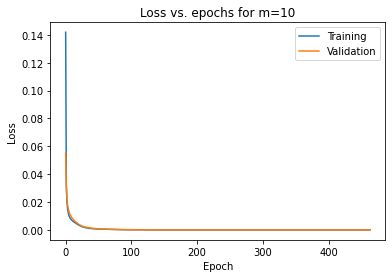

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=10')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd10m10')

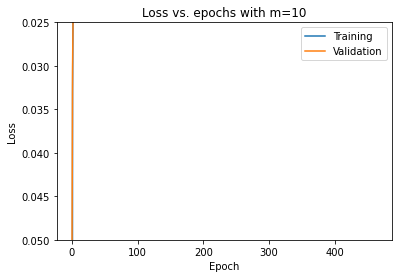

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs with m=10')
plt.ylabel('Loss')
plt.ylim((0.050, 0.025))
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
p_norm10, r_norm_10 = norms(model)
norms(model)

(2.0983715, 0.02423830032348633)

In [ ]:
pred_train= model.predict(X_train)
MSE10_train =mean_squared_error(y_train,pred_train)

pred= model.predict(X_test)
MSE10_test = mean_squared_error(y_test,pred)
MSE10_train, MSE10_test

(4.050326300220152e-08, 1.7274996651165243e-06)

In [ ]:
uploaded = files.upload()

Saving norms.csv to norms (3).csv


In [ ]:
df = pd.read_csv('norms (3).csv')
x = df['Unnamed: 0']
y1 = df['path_norms']
y2 = df['rkhs_norms']
df


,Unnamed: 0,path_norms,rkhs_norms
0,0,8.106727,0.118071
1,1,6.958734,0.096565
2,2,6.452098,0.086682
3,3,6.126353,0.081120
4,4,5.876729,0.077183
...,...,...,...
459,459,2.097858,0.024245
460,460,2.097511,0.024238
461,461,2.097991,0.024242
462,462,2.097980,0.024240


In [ ]:
x.shape, y1.shape, y2.shape

((464,), (464,), (464,))

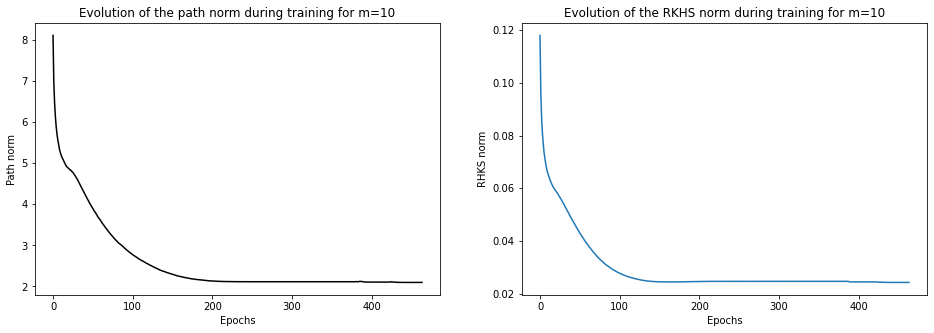

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].title.set_text('Evolution of the path norm during training for m=10')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[1].plot(x, y2)
axes[1].title.set_text('Evolution of the RKHS norm during training for m=10')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
fig.savefig('/content/drive/My Drive/ graph_m10_d10.png')

In [ ]:
loss = history.history['loss']
val_loss = (history.history['val_loss'])

In [ ]:
len(loss)

464

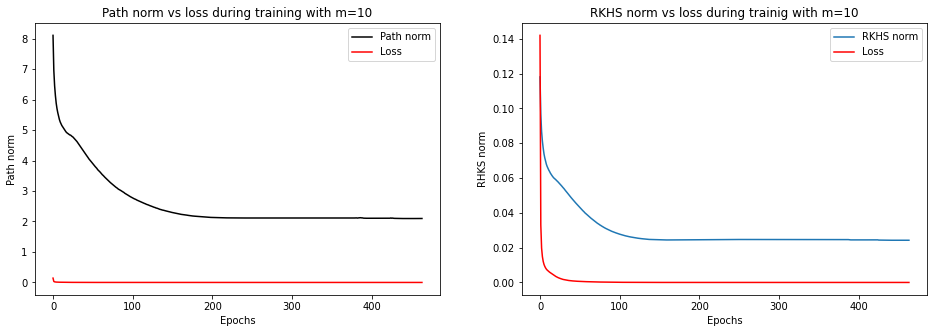

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].title.set_text('Path norm vs loss during training with m=10')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=10')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss'])
fig.savefig('/content/drive/My Drive/normvsloss_m10_d10.png')

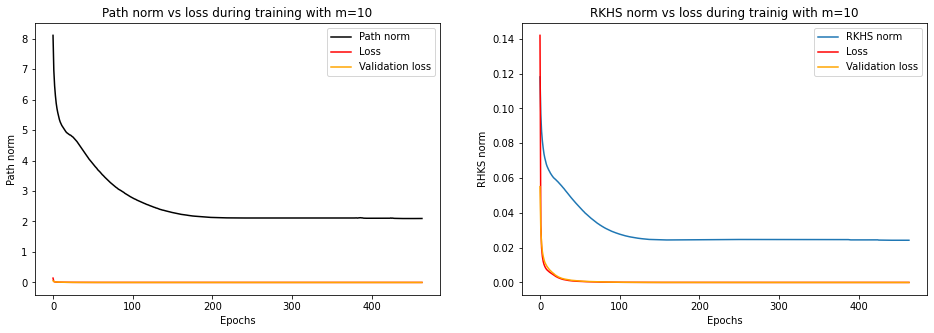

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=10')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=10')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/valloss_m10_d10.png')

#### m=1000

In [ ]:
model4 = keras.models.Sequential([
    keras.layers.Dense(1000, activation="relu"),
    keras.layers.Dense(1, activation="linear") 
])

In [ ]:
model4.compile(loss="MSE", optimizer=opt, metrics=['accuracy'])

In [ ]:
earlystopping4 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [ ]:
history = model4.fit(X_train, y_train, batch_size=32, epochs = 1000, validation_data = (X_val, y_val), verbose=False, callbacks=[earlystopping4])

In [ ]:
class CheckpointCallback(Callback): 

  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms4.csv'))
      
    
ckpt_callback4 =CheckpointCallback('/content/drive/My Drive')

In [ ]:
model4 = keras.models.Sequential([
    keras.layers.Dense(1000, activation="relu"),
    keras.layers.Dense(1, activation="linear") 
])

In [ ]:
model4.compile(loss="MSE", optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs = 1000, validation_data = (X_val, y_val), callbacks=[earlystopping, ckpt_callback4], verbose=False)

In [ ]:
from matplotlib.pyplot import figure

In [ ]:
uploaded = files.upload()

Saving norms4.csv to norms4 (1).csv


In [ ]:
df4 = pd.read_csv("norms4 (1).csv")


In [ ]:
x = df4['Unnamed: 0']
y1 = df4['path_norms']
y2 = df4['rkhs_norms']

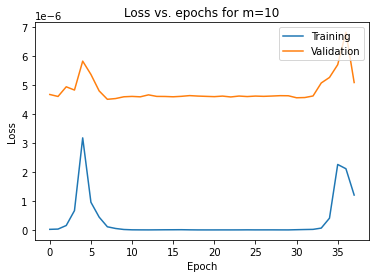

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=10')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd10m1000')

In [ ]:
loss = history.history['loss']
val_loss = (history.history['val_loss'])


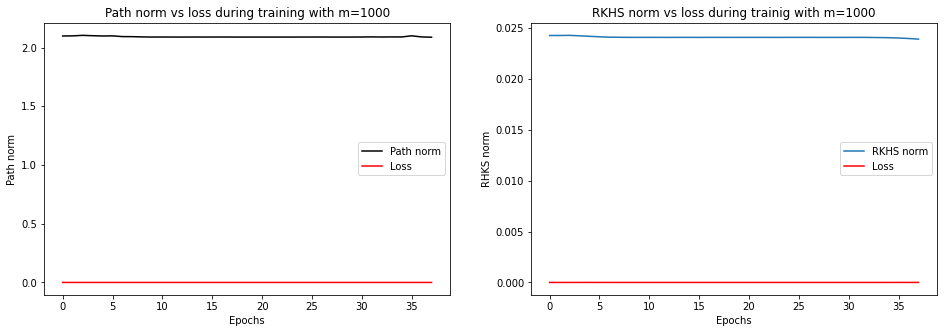

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].title.set_text('Path norm vs loss during training with m=1000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=1000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss'])
fig.savefig('/content/drive/My Drive/normvsloss_m1000_d10.png')

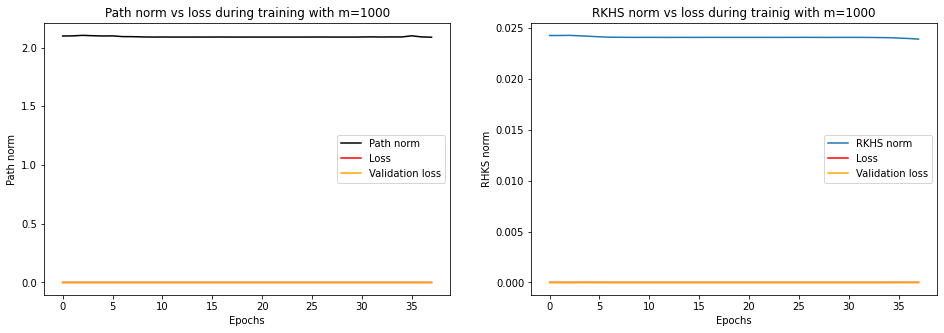

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=1000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=1000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/valloss_m1000_d10.png')

In [ ]:
pred_train= model4.predict(X_train)
MSEm1000_train = mean_squared_error(y_train,pred_train)

pred= model4.predict(X_test)
MSEm1000_test = mean_squared_error(y_test,pred)

#### m = 100,000

In [ ]:
model5 = keras.models.Sequential([
    keras.layers.Dense(100000, activation="relu"),
    keras.layers.Dense(1, activation="linear") 
])

In [ ]:
model5.compile(loss="MSE", optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model5.fit(X_train, y_train, batch_size=32, epochs = 1000, validation_data = (X_val, y_val), verbose=False, callbacks=[earlystopping])

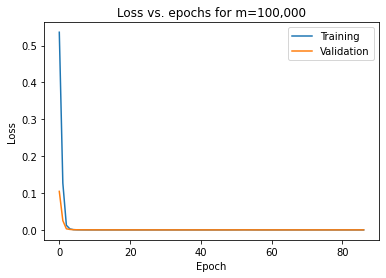

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=100,000')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd10m10x5')

In [ ]:
class CheckpointCallback(Callback): 

  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms5.csv'))
      
    
ckpt_callback5 =CheckpointCallback('/content/drive/My Drive')

In [ ]:
model5 = keras.models.Sequential([
    keras.layers.Dense(100000, activation="relu"),
    keras.layers.Dense(1, activation="linear") 
])

In [ ]:
model5.compile(loss="MSE", optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model5.fit(X_train, y_train, batch_size=32, epochs = 1000, validation_data = (X_val, y_val), verbose=False, callbacks=[earlystopping, ckpt_callback5])

In [ ]:
uploaded = files.upload()

Saving norms5.csv to norms5 (1).csv


In [ ]:
df5 = pd.read_csv("norms5 (1).csv")

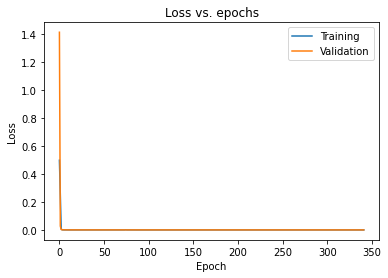

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
x = df5['Unnamed: 0']
y1 = df5['path_norms']
y2 = df5['rkhs_norms']


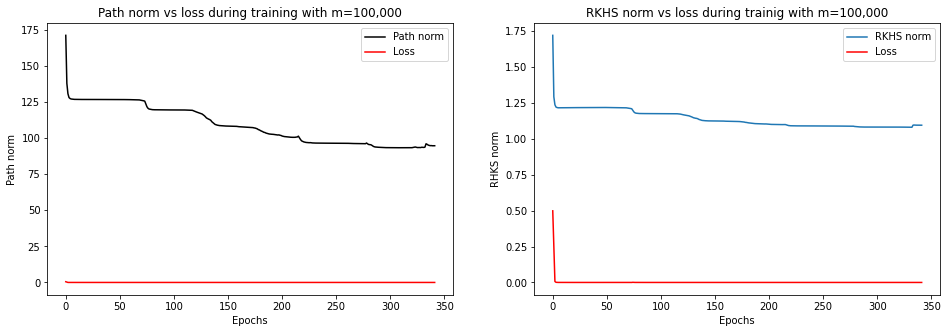

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].title.set_text('Path norm vs loss during training with m=100,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=100,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss'])
fig.savefig('/content/drive/My Drive/normvsloss_m10x5_d10.png')

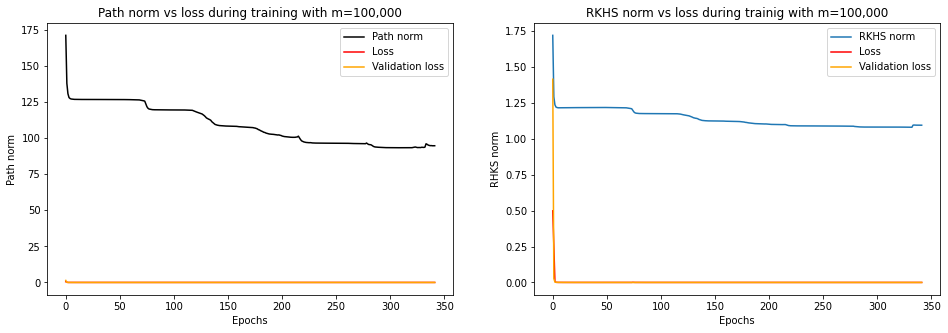

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=100,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=100,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/val_loss_m1056_d10.png')

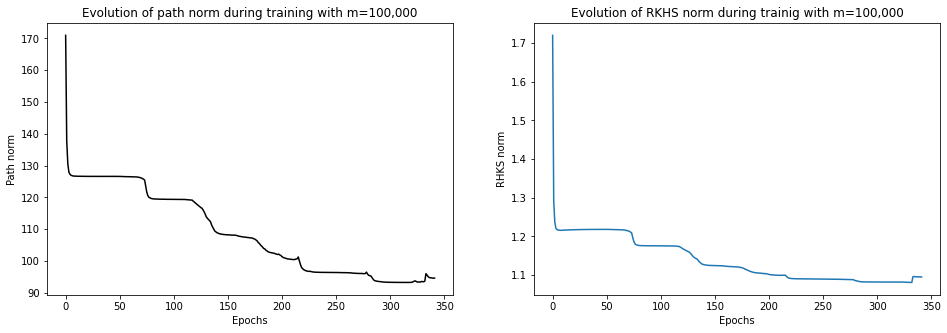

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
#axes[0].plot(x, loss, color='red')
#axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Evolution of path norm during training with m=100,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
#axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
#axes[1].plot(x, loss, color='red')
#axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('Evolution of RKHS norm during trainig with m=100,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
#axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/normsm10x6_d10.png')

In [ ]:
pnm6, rnm6 = norms(model5)

In [ ]:
pred_train= model5.predict(X_train)
MSEm10x5_train = mean_squared_error(y_train,pred_train)

pred= model5.predict(X_test)
MSEm10x5_test = mean_squared_error(y_test,pred)

#### m: 1,000,000

In [ ]:
model6 = keras.models.Sequential([
    keras.layers.Dense(1000000, activation="relu"),
    keras.layers.Dense(1, activation="linear") 
])

In [ ]:
model6.compile(loss="MSE", optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model6.fit(X_train, y_train, batch_size=32, epochs = 1000, validation_data = (X_val, y_val), verbose=False, callbacks=[earlystopping])

In [ ]:
class CheckpointCallback(Callback): 

  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms6.csv'))
      
    
ckpt_callback6 =CheckpointCallback('/content/drive/My Drive')

In [ ]:
model6 = keras.models.Sequential([
    keras.layers.Dense(1000000, activation="relu"),
    keras.layers.Dense(1, activation="linear") 
])

In [ ]:
model6.compile(loss="MSE", optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model6.fit(X_train, y_train, batch_size=32, epochs = 1000, validation_data = (X_val, y_val), verbose=False, callbacks=[earlystopping, ckpt_callback6])

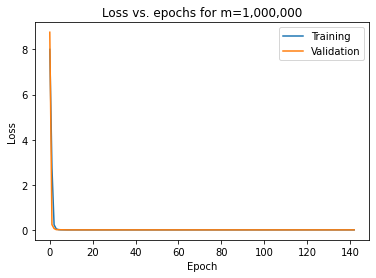

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=1,000,000')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd10m10x6')

In [ ]:
uploaded = files.upload() 

Saving norms6.csv to norms6 (1).csv


In [ ]:
df6 = pd.read_csv("norms6 (1).csv")

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

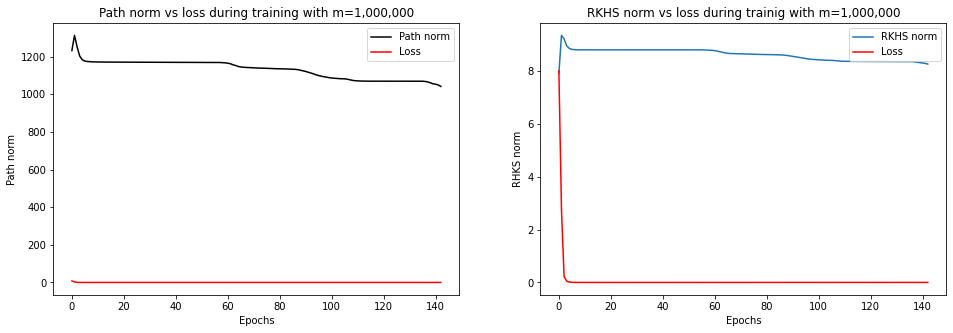

In [ ]:
x = df6['Unnamed: 0']
y1 = df6['path_norms']
y2 = df6['rkhs_norms']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].title.set_text('Path norm vs loss during training with m=1,000,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=1,000,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss'])
fig.savefig('/content/drive/My Drive/normvsloss_m10x6_d10.png')

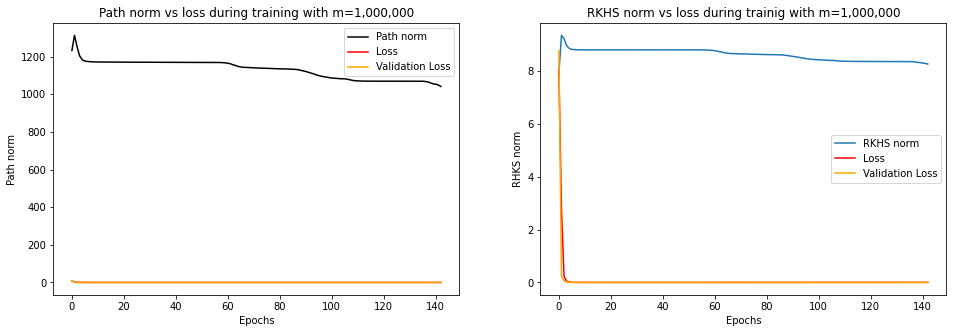

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=1,000,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation Loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=1,000,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation Loss'])
fig.savefig('/content/drive/My Drive/valloss_m10x6_d10.png')

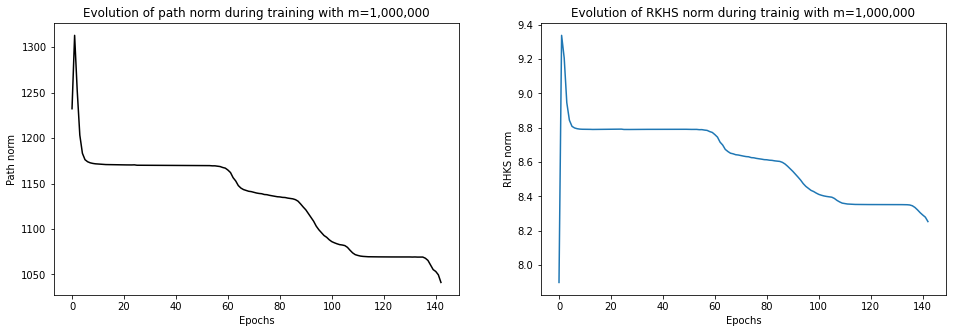

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
#axes[0].plot(x, loss, color='red')
#axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Evolution of path norm during training with m=1,000,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
#axes[0].legend(['Path norm', 'Loss', 'Validation Loss'])
axes[1].plot(x, y2)
#axes[1].plot(x, loss, color='red')
#axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('Evolution of RKHS norm during trainig with m=1,000,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
#axes[1].legend(['RKHS norm', 'Loss', 'Validation Loss'])
fig.savefig('/content/drive/My Drive/norms_m10x6_d10.png')

# d = 100

We will now increase the dimension $d$ to 100. 

In [ ]:
np.random.seed(0)
d = 100
n = 1000

#### Generating $x$ and $w^*$

In [ ]:
#Generating x-values. X is in [-1,1]^d 
X2 = np.random.uniform(-1,1, (1500,100))

In [ ]:
#choosing W* on the unit ball with ||W||=1 d-length 
w2 = np.random.uniform(-1,1, (100)) # d=100
w_n2 = np.linalg.norm(w2, ord=1, axis=0, keepdims=True)
w_star2 = (w2 / w_n2)

In [ ]:
w_star2.shape

(100,)

#### Target function

In [ ]:
y2 = relu(np.inner(w_star2, X2)) #target function
y2.shape

(1500,)

##### X_train, X_test, X_val 

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=1)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.25, random_state=1)

### Kernel Ridge Regression 

#### $ λ = 0.1 $

In [ ]:
c2 = kernel_coefficients(X2_train, y2_train, 0.1)
y2_pred = kernel_model(X2_train, X2_train, c2)

y2_pred.shape

(900,)

#### Mean Squared Error

In [ ]:
MSE2 = mean_squared_error(y2_train, y2_pred)
MSE2

0.0013552838696736767

#### $λ = 0$ 

In [ ]:
c20 = kernel_coefficients(X2_train, y2_train, 0)
y20_pred = kernel_model(X2_train, X2_train, c20)

In [ ]:
MSE20 = mean_squared_error(y2_train, y20_pred)
MSE20

1.3650821105920226e+27

#### Grid search for $λ$ using X_val 

In [ ]:
d = {}
for c in params:
  c2_vals = kernel_coefficients(X2_val, y2_val, c)
  #d[c] = c_vals
  temp2 = kernel_model(X2_val, X2_val, c2_vals)
  d[c] = mean_squared_error(y2_val, temp2)
d

{0.01: 0.0009754167380176023,
 0.02: 0.0011982771293662861,
 0.03: 0.0013673217478352801,
 0.04: 0.0014906684998962534,
 0.05: 0.0014669376066316574,
 0.060000000000000005: 0.0015344248549341302,
 0.06999999999999999: 0.0015911884420200318,
 0.08: 0.0015800073587727314,
 0.09: 0.0016578288075914632,
 0.09999999999999999: 0.0016809274695500258,
 0.11: 0.0017305525027293224,
 0.12: 0.0017487979786244782,
 0.13: 0.0017002089904082696,
 0.14: 0.0017729671904847548,
 0.15000000000000002: 0.0017350761740861334,
 0.16: 0.0017587338297996636,
 0.17: 0.0017935669253733811,
 0.18000000000000002: 0.0018292954437415124,
 0.19: 0.0018428631465396905,
 0.2: 0.0018206063438161461,
 0.21000000000000002: 0.0018579336948118775,
 0.22: 0.0018980649780214257,
 0.23: 0.0018784176747369222,
 0.24000000000000002: 0.0019174876462034662,
 0.25: 0.001898085780801698,
 0.26: 0.0019154441929720779,
 0.27: 0.0019282366038300284,
 0.28: 0.0019398606052018381,
 0.29000000000000004: 0.0019503275534841747,
 0.3: 0.001

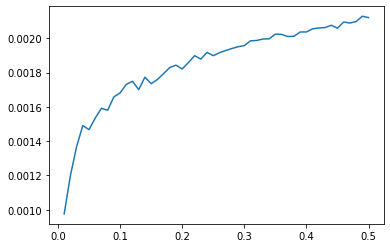

In [ ]:

plt.plot(list(d.keys()), list(d.values()))

In [ ]:
params2 = np.arange(0, 0.0101, 0.0001)
params2

array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031,
       0.0032, 0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039,
       0.004 , 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047,
       0.0048, 0.0049, 0.005 , 0.0051, 0.0052, 0.0053, 0.0054, 0.0055,
       0.0056, 0.0057, 0.0058, 0.0059, 0.006 , 0.0061, 0.0062, 0.0063,
       0.0064, 0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007 , 0.0071,
       0.0072, 0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079,
       0.008 , 0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087,
       0.0088, 0.0089, 0.009 , 0.0091, 0.0092, 0.0093, 0.0094, 0.0095,
       0.0096, 0.0097, 0.0098, 0.0099, 0.01  ])

In [ ]:
d = {}
for c in params2:
  c2_vals = kernel_coefficients(X2_val, y2_val, c)
  #d[c] = c_vals
  temp2 = kernel_model(X2_val, X2_val, c2_vals)
  d[c] = mean_squared_error(y2_val, temp2)
d

{0.0: 0.0516623708003162,
 0.0001: 0.00775273971674513,
 0.0002: 0.004991741418666414,
 0.00030000000000000003: 0.008845368606261837,
 0.0004: 0.0026945410758435298,
 0.0005: 0.003317502961072907,
 0.0006000000000000001: 0.0025319794458365068,
 0.0007: 0.0013243885091614393,
 0.0008: 0.000675702020291396,
 0.0009000000000000001: 0.004162552798958354,
 0.001: 0.001228871207531087,
 0.0011: 0.0026520122527468435,
 0.0012000000000000001: 0.0005333086775491243,
 0.0013000000000000002: 0.0006116960932029062,
 0.0014: 0.0015296835687107822,
 0.0015: 0.0006197864054221802,
 0.0016: 0.0005675836249422262,
 0.0017000000000000001: 0.001088342295201529,
 0.0018000000000000002: 0.0005914681408613966,
 0.0019: 0.0007212568228948732,
 0.002: 0.000690131751162465,
 0.0021000000000000003: 0.0006369365856542498,
 0.0022: 0.0009575351995510682,
 0.0023: 0.0005782373976976346,
 0.0024000000000000002: 0.0006240848193867633,
 0.0025: 0.0007881982865869716,
 0.0026000000000000003: 0.0006292044563843063,
 0.

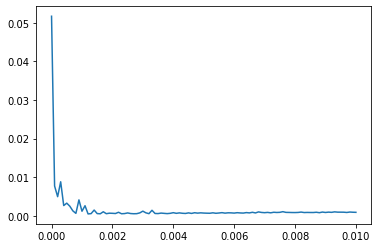

In [ ]:
plt.plot(list(d.keys()), list(d.values()))

#### Testing $\lambda = 0.002$

In [ ]:
c2_test = kernel_coefficients(X2_test, y2_test, 0.002)
y2_pred_test = kernel_model(X2_test, X2_test, c2_test)

In [ ]:
mean_squared_error(y2_test, y2_pred_test)

0.0007521480366020502

#### RKHS norm 

In [ ]:
kernel_matrix2 = k(X2_test, X2_test)
ct_test2 = kernel_matrix2 @ c2_test
np.sqrt(np.inner(ct_test2, c2_test))

8.200219131179146

In [ ]:
kernel_matrix22 = k(X2_train, X2_train)
ct_2 = kernel_matrix22 @ c2 
kernel_rkhs2 = np.sqrt(np.inner(ct_2, c2))
kernel_rkhs2

1.2945655282806234

## Two layer neural network ($d=100$)

In [ ]:
#model2 = keras.models.Sequential([
    #keras.layers.Dense(10, input_shape= (100,), activation="relu"), 
    #keras.layers.Dense(1, activation='linear')
#])

In [ ]:
#model2.compile(loss="MSE",
                     #optimizer=opt,
               #metrics = "accuracy")

In [ ]:
#history = model2.fit(X2_train, y2_train, batch_size=32, epochs=1000, validation_data = (X2_val, y2_val), verbose=0)

In [ ]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Loss vs. epochs')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['Training', 'Validation'], loc='upper right')
#plt.show()

#### Mean Squared Error

In [ ]:
#pred_train2= model2.predict(X2_train)
#print(mean_squared_error(y2_train,pred_train2))

#pred2= model2.predict(X2_test)
#print(mean_squared_error(y2_test,pred2))

#### Path norm 

In [ ]:
#norms(model2)

#### Early stopping

In [ ]:
model2 = keras.models.Sequential([
    keras.layers.Dense(10, input_shape =(100,), activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model2.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
earlystopping2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [ ]:
history = model2.fit(X2_train, y2_train, batch_size=32, epochs = 1000, validation_data = (X2_val, y2_val), verbose=False, callbacks=[earlystopping2])

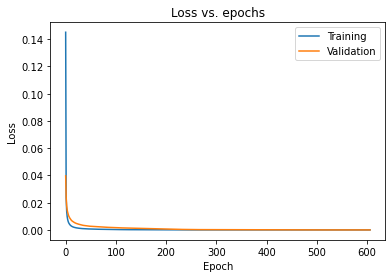

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### Callbacks for model2

In [ ]:
from tensorflow.keras.callbacks import Callback 

class CheckpointCallback(Callback): 

  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms2.csv'))
      
    
ckpt_callback2 =CheckpointCallback('/content/drive/My Drive')



In [ ]:
model2 = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=(100,), activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model2.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model2.fit(X2_train, y2_train, batch_size=32, epochs = 1000, validation_data = (X2_val, y2_val), callbacks=[earlystopping2, ckpt_callback2], verbose=False)

In [ ]:
norms(model2)

(1.0503728, 0.000660862633958459)

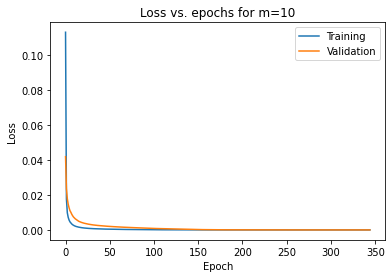

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=10')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd100m10')

In [ ]:
uploaded = files.upload()

Saving norms2.csv to norms2.csv


In [ ]:
df2 = pd.read_csv("norms2.csv")

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

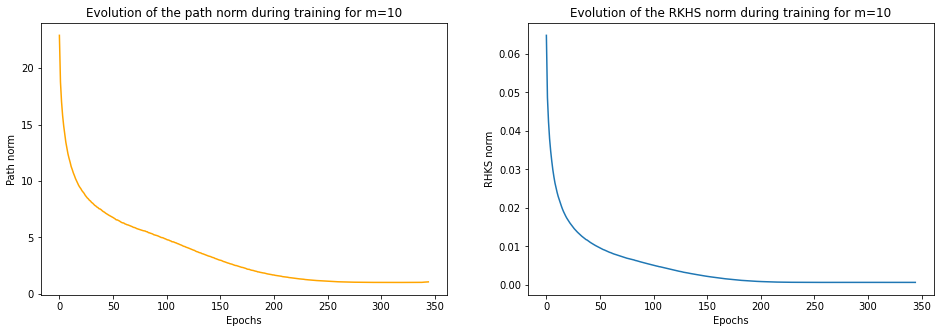

In [ ]:
x = df2['Unnamed: 0']
y1 = df2['path_norms']
y2 = df2['rkhs_norms']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='orange')
axes[0].title.set_text('Evolution of the path norm during training for m=10')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[1].plot(x, y2)
axes[1].title.set_text('Evolution of the RKHS norm during training for m=10')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
fig.savefig('/content/drive/My Drive/ graph_m10_d100.png')

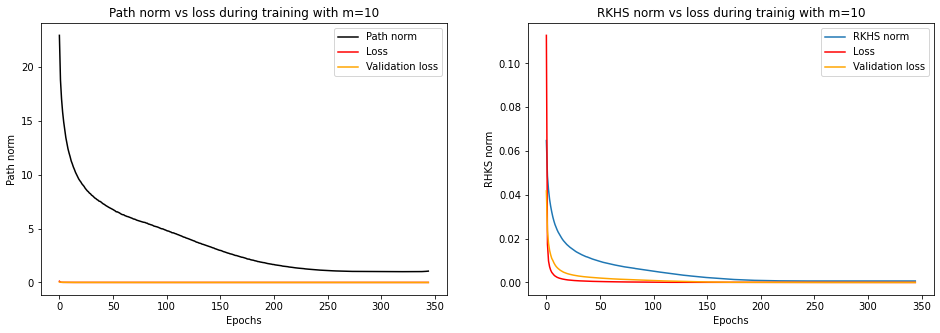

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=10')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=10')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/valloss_m10_d100.png')

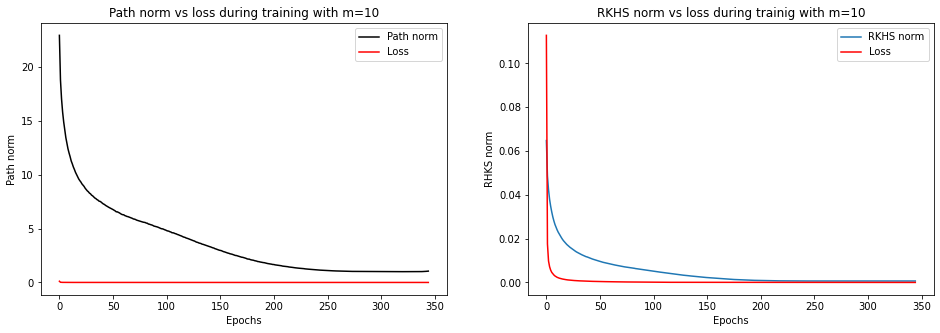

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
#axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=10')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
#axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=10')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss'])
fig.savefig('/content/drive/My Drive/loss_m10_d100.png')

#### m = 1000

In [ ]:
model7 = keras.models.Sequential([
    keras.layers.Dense(1000, input_shape =(100,), activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model7.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model7.fit(X2_train, y2_train, batch_size=32, epochs = 1000, validation_data = (X2_val, y2_val), verbose=False, callbacks=[earlystopping2])

In [ ]:
class CheckpointCallback(Callback): 

  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms7.csv'))
      
    
ckpt_callback7 =CheckpointCallback('/content/drive/My Drive')


In [ ]:
model7 = keras.models.Sequential([
    keras.layers.Dense(1000, activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model7.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model7.fit(X2_train, y2_train, batch_size=32, epochs = 1000, validation_data = (X2_val, y2_val), verbose=False, callbacks=[earlystopping2, ckpt_callback7])

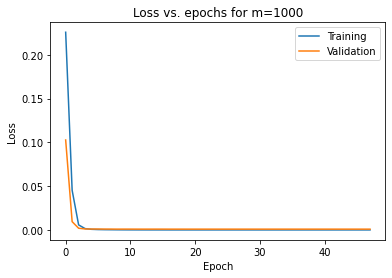

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=1000')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd100m1000')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
uploaded = files.upload()

Saving norms7.csv to norms7.csv


In [ ]:
df7 = pd.read_csv('norms7.csv')

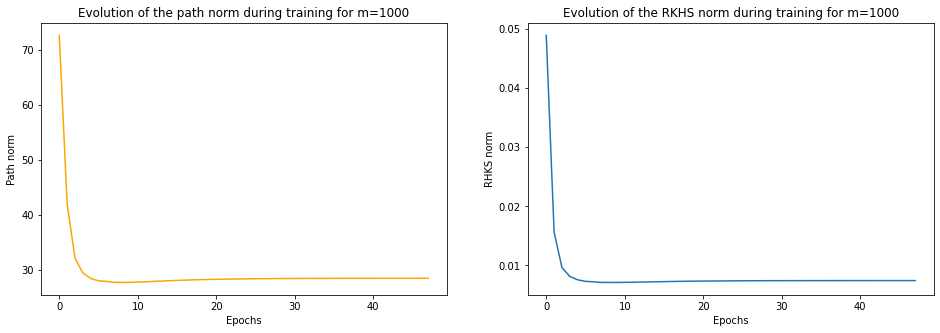

In [ ]:
x = df7['Unnamed: 0']
y1 = df7['path_norms']
y2 = df7['rkhs_norms']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='orange')
axes[0].title.set_text('Evolution of the path norm during training for m=1000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[1].plot(x, y2)
axes[1].title.set_text('Evolution of the RKHS norm during training for m=1000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
fig.savefig('/content/drive/My Drive/ graph_m1000_d100.png')

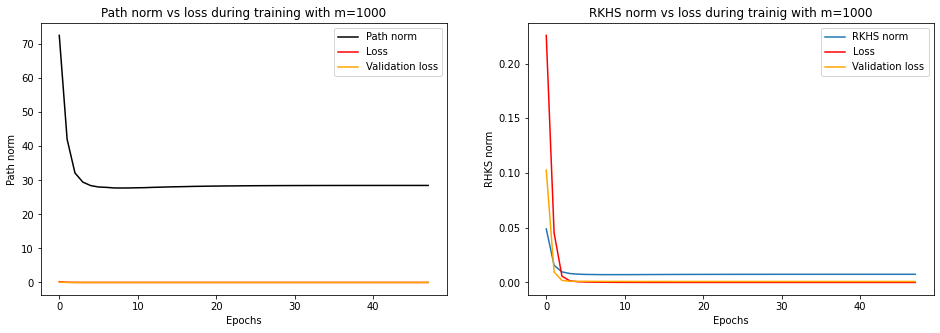

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=1000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=1000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/valloss_m1000_d100.png')


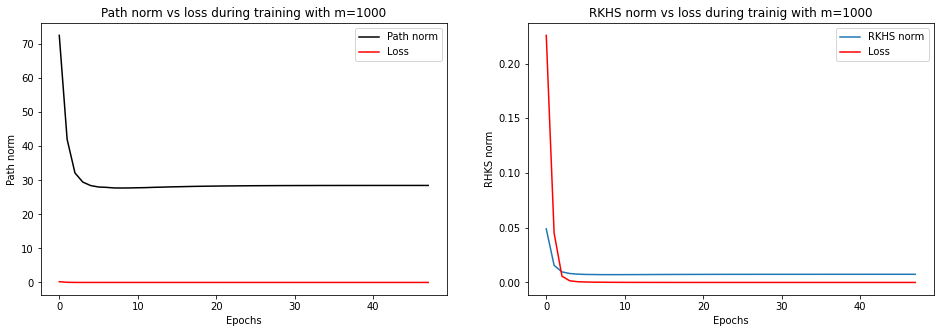

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
#axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=1000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
#axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=1000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss'])
fig.savefig('/content/drive/My Drive/loss_m1000_d100.png')


#### m= 100,000

In [ ]:
model8 = keras.models.Sequential([
    keras.layers.Dense(100000, activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model8.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model8.fit(X2_train, y2_train, batch_size=32, epochs = 1000, validation_data = (X2_val, y2_val), verbose=False, callbacks=[earlystopping2])

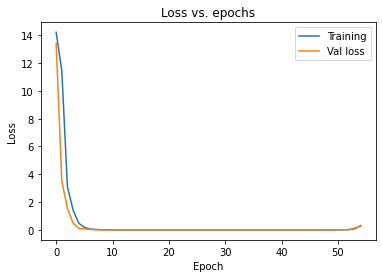

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Val loss'], loc='upper right')
plt.show()

In [ ]:
class CheckpointCallback(Callback): 

  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms8.csv'))
      
    
ckpt_callback8 =CheckpointCallback('/content/drive/My Drive')

In [ ]:
model8 = keras.models.Sequential([
    keras.layers.Dense(100000, activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model8.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model8.fit(X2_train, y2_train, batch_size=32, epochs = 1000, validation_data = (X2_val, y2_val), verbose=False, callbacks=[earlystopping2, ckpt_callback8])

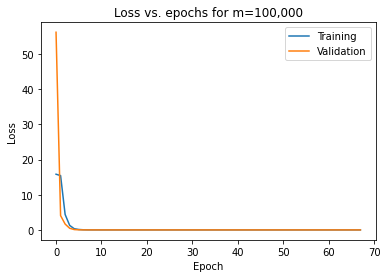

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=100,000')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd100m10x5')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
uploaded = files.upload()

Saving norms8.csv to norms8.csv


In [ ]:
df8 = pd.read_csv('norms8.csv')

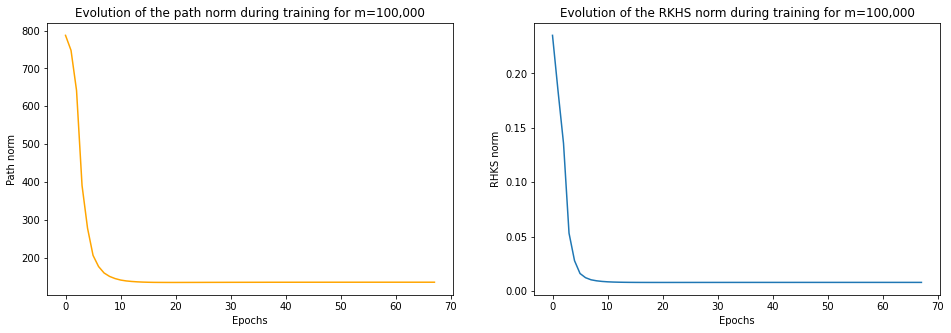

In [ ]:
x = df8['Unnamed: 0']
y1 = df8['path_norms']
y2 = df8['rkhs_norms']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='orange')
axes[0].title.set_text('Evolution of the path norm during training for m=100,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[1].plot(x, y2)
axes[1].title.set_text('Evolution of the RKHS norm during training for m=100,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
fig.savefig('/content/drive/My Drive/ graph_m10x5_d100.png')

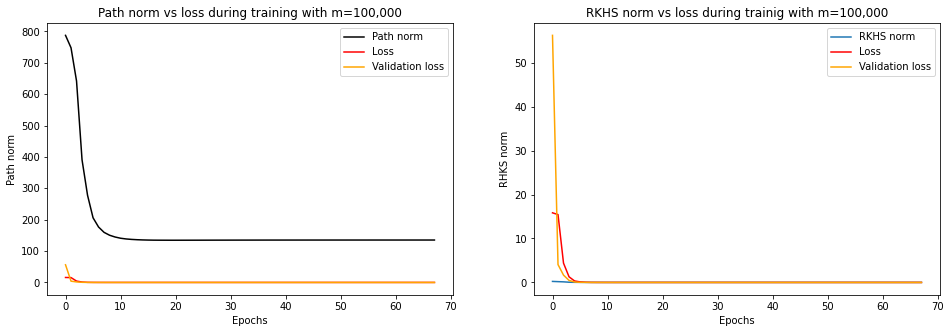

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=100,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=100,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/valloss_m10x5_d100.png')


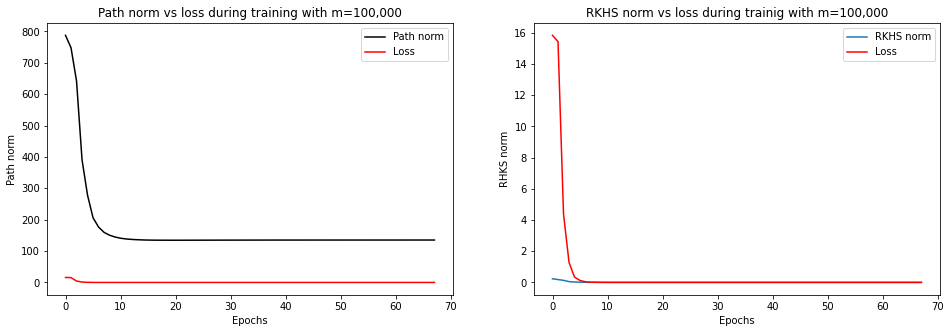

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
#axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=100,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
#axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=100,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss'])
fig.savefig('/content/drive/My Drive/loss_m10x5_d100.png')


#### m = 1,000,000

In [ ]:
model9 = keras.models.Sequential([
    keras.layers.Dense(1000000, input_shape=(100,), activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model9.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model8.fit(X2_train, y2_train, batch_size=32, epochs = 1000, validation_data = (X2_val, y2_val), verbose=False, callbacks=[earlystopping2])

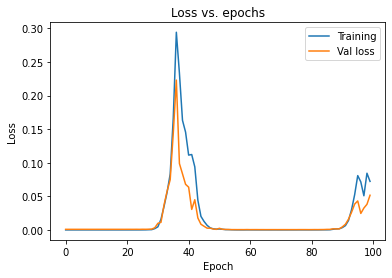

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Val loss'], loc='upper right')
plt.show()

In [ ]:
class CheckpointCallback(Callback): 

  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms9.csv'))
      
    
ckpt_callback9 =CheckpointCallback('/content/drive/My Drive')

In [ ]:
model9 = keras.models.Sequential([
    keras.layers.Dense(1000000, input_shape=(100,), activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model9.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model8.fit(X2_train, y2_train, batch_size=32, epochs = 1000, validation_data = (X2_val, y2_val), verbose=False, callbacks=[earlystopping2, ckpt_callback9])

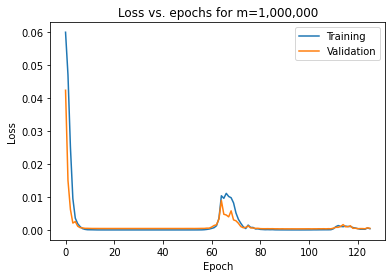

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=1,000,000')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd100m10x6')


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
uploaded = files.upload()

Saving norms9.csv to norms9.csv


In [ ]:
df9 = pd.read_csv('norms9.csv')

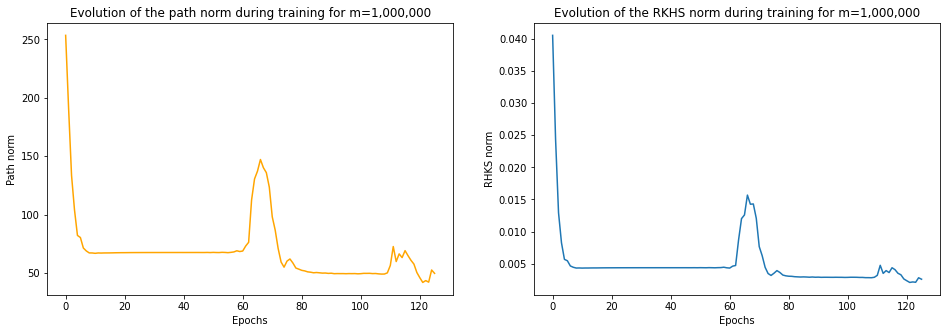

In [ ]:
x = df9['Unnamed: 0']
y1 = df9['path_norms']
y2 = df9['rkhs_norms']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='orange')
axes[0].title.set_text('Evolution of the path norm during training for m=1,000,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[1].plot(x, y2)
axes[1].title.set_text('Evolution of the RKHS norm during training for m=1,000,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
fig.savefig('/content/drive/My Drive/ graph_m10x6_d100.png')

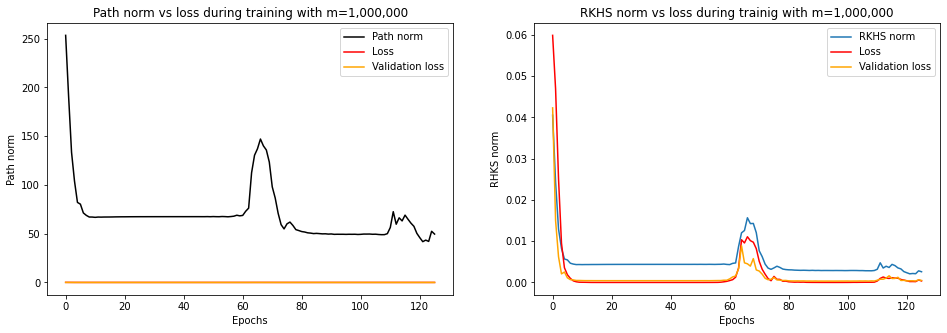

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=1,000,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=1,000,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/valloss_m10x6_d100.png')

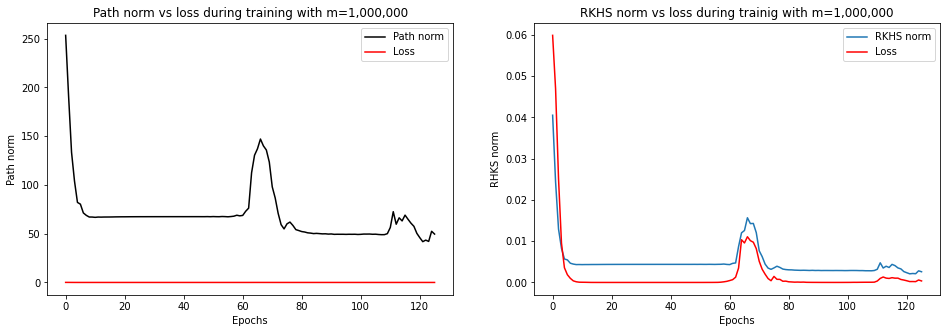

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
#axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=1,000,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
#axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=1,000,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/loss_m10x6_d100.png')

# $d = 1000 $

### Generating data $x$ and $w^*$ 

In [ ]:
np.random.seed(0)
d = 1000


In [ ]:
#Generating x-values. X is in [-1,1]^d 
X3 = np.random.uniform(-1,1, (1500,d)) #x is n by d vector


In [ ]:
#choosing W* on the unit ball with ||W||=1 d-length 
w3 = np.random.uniform(-1,1, (1000)) # d=1000
w_n3 = np.linalg.norm(w3, ord=1, axis=0, keepdims=True)
w_star3 = (w3 / w_n3)

In [ ]:
w_star3.shape

(1000,)

#### Target function $f^* = σ(⟨w^* , x ⟩)$

In [ ]:
#target function
y3 = relu(np.inner(w_star3, X3))

##### X_train, X_test, X_val

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=1)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3_train, y3_train, test_size=0.25, random_state=1)

In [ ]:
X3_train.shape, X3_test.shape, X3_val.shape

((900, 1000), (300, 1000), (300, 1000))

## Kernel ridgre regression 





#### $λ = 0.1$ 

In [ ]:
c3 = kernel_coefficients(X3_train, y3_train, 0.1)
y3_pred = kernel_model(X3_train, X3_train, c3)

y3_pred.shape

(900,)

#### Mean Squared Error 

In [ ]:
MSE3 = mean_squared_error(y3_train, y3_pred)
MSE3

0.00016881115453486604

#### $\lambda = 0$

In [ ]:
c30 = kernel_coefficients(X3_train, y3_train, 0)
y30_pred = kernel_model(X3_train, X3_train, c30)

In [ ]:
mean_squared_error(y3_train, y30_pred)

8.205992169874239e+27

#### Grid search for $λ$

In [ ]:
d = {}
for c in params:
  c3_vals = kernel_coefficients(X3_val, y3_val, c)
  #d[c] = c_vals
  temp3 = kernel_model(X3_val, X3_val, c3_vals)
  d[c] = mean_squared_error(y3_val, temp3)
d

{0.01: 0.00017821533541014382,
 0.02: 0.00018998926672901211,
 0.03: 0.00020104699800392668,
 0.04: 0.00020631815875414268,
 0.05: 0.00021322675408583103,
 0.060000000000000005: 0.00021547925053831107,
 0.06999999999999999: 0.0002192356031441959,
 0.08: 0.00022235445159722312,
 0.09: 0.00022544479420386925,
 0.09999999999999999: 0.00022767297521114185,
 0.11: 0.00022856324560602604,
 0.12: 0.00023015740656575357,
 0.13: 0.00023151117814026724,
 0.14: 0.00023257041717027912,
 0.15000000000000002: 0.00023430503978419715,
 0.16: 0.00023456573466259077,
 0.17: 0.00023535155191973652,
 0.18000000000000002: 0.00023609227895241512,
 0.19: 0.000236828024818871,
 0.2: 0.00023782249035402805,
 0.21000000000000002: 0.00023824776195643282,
 0.22: 0.0002385561997722479,
 0.23: 0.0002392974305120348,
 0.24000000000000002: 0.00023971566220835281,
 0.25: 0.00023994091689577112,
 0.26: 0.0002406037630292329,
 0.27: 0.00024063756303477384,
 0.28: 0.0002411692124362326,
 0.29000000000000004: 0.0002413781

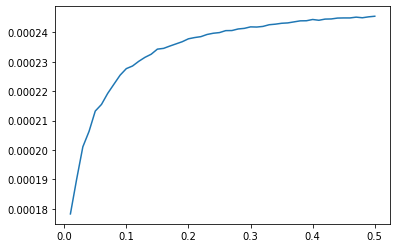

In [ ]:
plt.plot(list(d.keys()), list(d.values()))

In [ ]:
d = {}
for c in params2:
  c3_vals = kernel_coefficients(X3_val, y3_val, c)
  #d[c] = c_vals
  temp3 = kernel_model(X3_val, X3_val, c3_vals)
  d[c] = mean_squared_error(y3_val, temp3)
d

{0.0: 0.00777479166836112,
 0.0001: 0.0001255180508879758,
 0.0002: 8.111882164957962e-05,
 0.00030000000000000003: 0.00012011411052383505,
 0.0004: 9.844087606971102e-05,
 0.0005: 0.0001013528533582971,
 0.0006000000000000001: 0.00011359487453346334,
 0.0007: 0.00011878616059505201,
 0.0008: 0.00011970649914375661,
 0.0009000000000000001: 0.00013601858165235425,
 0.001: 0.00013282303586453664,
 0.0011: 0.00013179764505503132,
 0.0012000000000000001: 0.0001398203535521027,
 0.0013000000000000002: 0.00014153514985774143,
 0.0014: 0.00014169842805595383,
 0.0015: 0.00014466090446631455,
 0.0016: 0.00014384386355240292,
 0.0017000000000000001: 0.0001464191523030429,
 0.0018000000000000002: 0.00014778914707659264,
 0.0019: 0.00014743606788204932,
 0.002: 0.0001501199272510179,
 0.0021000000000000003: 0.0001542361470202464,
 0.0022: 0.00015066894474278873,
 0.0023: 0.00015157008872250562,
 0.0024000000000000002: 0.00015411271543520558,
 0.0025: 0.0001551876368199543,
 0.0026000000000000003:

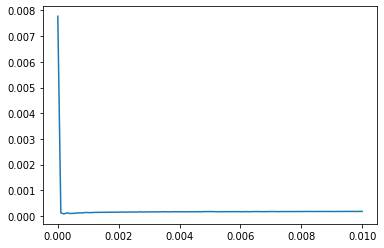

In [ ]:
plt.plot(list(d.keys()), list(d.values()))

#### Testing $\lambda =0.001 $ 

In [ ]:
c3_test = kernel_coefficients(X3_test, y3_test, 0.001)
y3_pred_test = kernel_model(X3_test, X3_test, c3_test)

In [ ]:
mean_squared_error(y3_test, y3_pred_test)

0.00010647462288573627

#### RKHS norm

In [ ]:
kernel_matrix3 = k(X3_test, X3_test)
ct_3test = kernel_matrix3 @ c3_test

In [ ]:
kernel_rkhs_norm3 = np.sqrt(np.inner(ct_3test, c3_test))
kernel_rkhs_norm3

2.5551468861440414

In [ ]:
kernel_matrix33 = k(X3_train, X3_train)
ct_3 = kernel_matrix33 @ c3


In [ ]:
kernel_rkhsnorm3 = np.sqrt(np.inner(ct_3, c3))
kernel_rkhsnorm3

0.37155221639386704

## Two layer neural network  

#### Early Stopping for model3 

In [ ]:
model3 = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=(1000,), activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model3.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
earlystopping3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [ ]:
history = model3.fit(X3_train, y3_train, batch_size=32, epochs = 1000, validation_data = (X3_val, y3_val), verbose=False, callbacks=[earlystopping3])

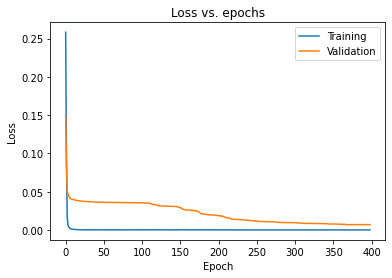

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### Callbacks model3

In [ ]:
class CheckpointCallback(Callback): 
  
  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms3.csv'))
      
    
ckpt_callback3 =CheckpointCallback('/content/drive/My Drive')


In [ ]:
model3 = keras.models.Sequential([
    keras.layers.Dense(10, input_shape = (1000,), activation="relu"),
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model3.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model3.fit(X3_train, y3_train, batch_size= 32, epochs = 1000, validation_data = (X3_val, y3_val), callbacks=[earlystopping3, ckpt_callback3], verbose=False)

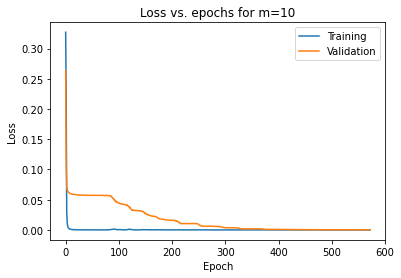

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=10')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd1000m10')


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
pred_train3= model3.predict(X3_train)
print(mean_squared_error(y3_train,pred_train3))

pred3= model3.predict(X3_test)
print(mean_squared_error(y3_test,pred3))

6.104265962706358e-06
0.00014295720518866638


In [ ]:
uploaded = files.upload()

Saving norms3.csv to norms3.csv


In [ ]:
df3 = pd.read_csv('norms3.csv')

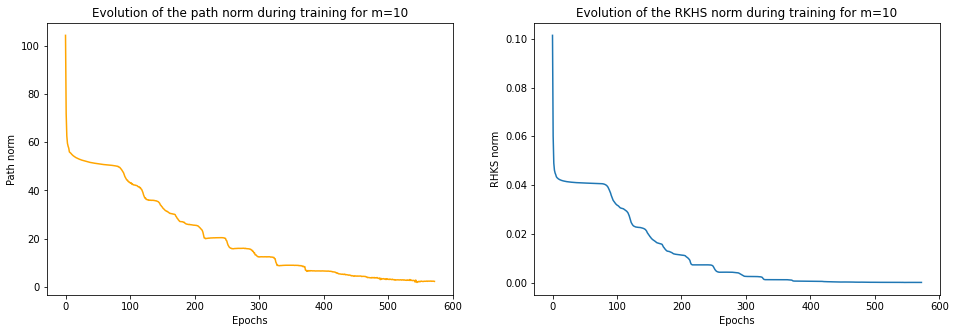

In [ ]:
x = df3['Unnamed: 0']
y1 = df3['path_norms']
y2 = df3['rkhs_norms']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='orange')
axes[0].title.set_text('Evolution of the path norm during training for m=10')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[1].plot(x, y2)
axes[1].title.set_text('Evolution of the RKHS norm during training for m=10')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
fig.savefig('/content/drive/My Drive/ graph_m10_d1000.png')

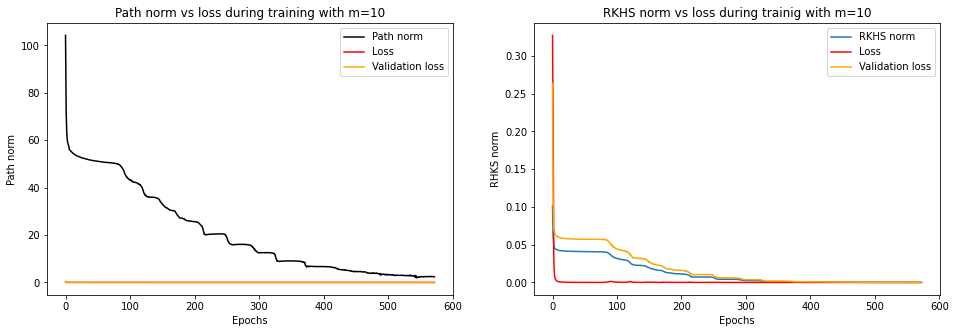

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=10')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=10')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/valloss_m10_d1000.png')


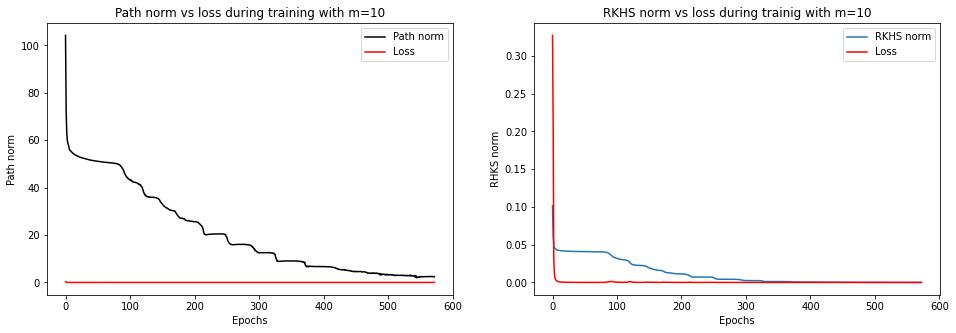

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
#axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=10')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
#axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=10')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/loss_m10_d1000.png')


# m = 1000

In [ ]:
model10 = keras.models.Sequential([
    keras.layers.Dense(1000, input_shape=(1000,), activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model10.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model3.fit(X3_train, y3_train, batch_size= 32, epochs = 1000, validation_data = (X3_val, y3_val), callbacks=[earlystopping3], verbose=False)

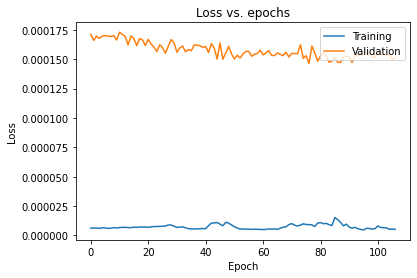

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
class CheckpointCallback(Callback): 
  
  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms10.csv'))
      
    
ckpt_callback10 =CheckpointCallback('/content/drive/My Drive')

In [ ]:
model10 = keras.models.Sequential([
    keras.layers.Dense(1000, input_shape=(1000,), activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model10.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model10.fit(X3_train, y3_train, batch_size= 32, epochs = 1000, validation_data = (X3_val, y3_val), callbacks=[earlystopping3, ckpt_callback10], verbose=False)

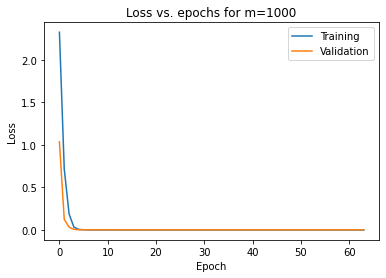

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=1000')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd1000m1000')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
uploaded = files.upload()

Saving norms10.csv to norms10.csv


In [ ]:
df10 = pd.read_csv('norms10.csv')

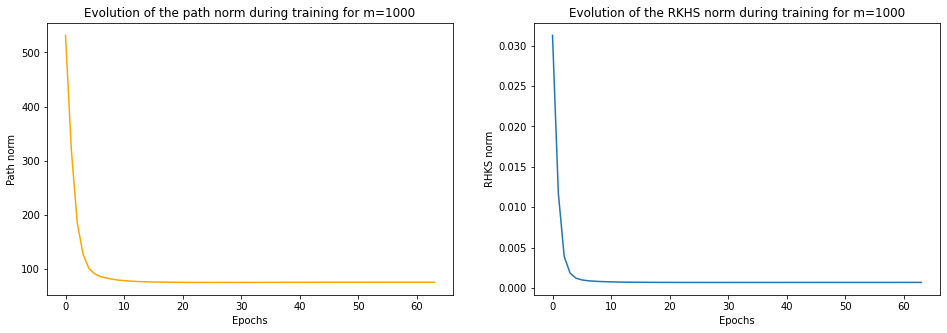

In [ ]:
x = df10['Unnamed: 0']
y1 = df10['path_norms']
y2 = df10['rkhs_norms']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='orange')
axes[0].title.set_text('Evolution of the path norm during training for m=1000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[1].plot(x, y2)
axes[1].title.set_text('Evolution of the RKHS norm during training for m=1000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
fig.savefig('/content/drive/My Drive/ graph_m1000_d1000.png')

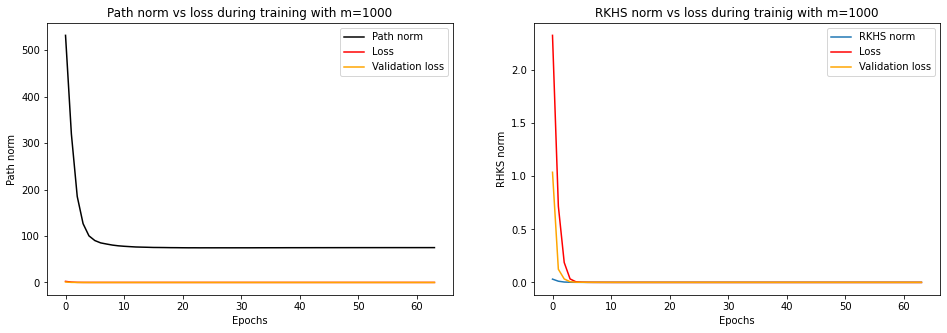

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=1000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=1000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/valloss_m1000_d1000.png')


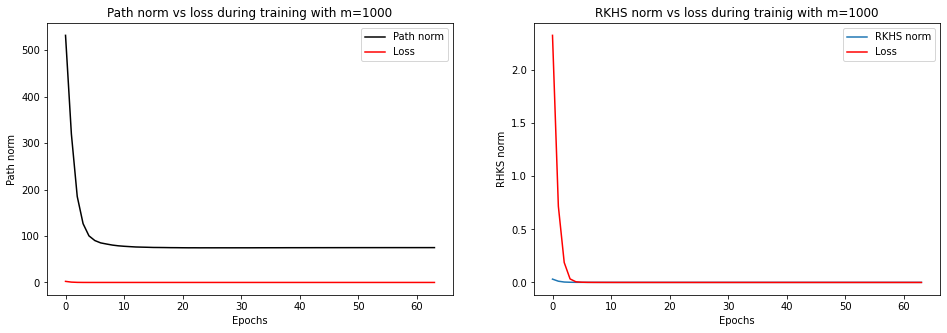

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
#axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=1000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
#axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=1000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/loss_m1000_d1000.png')


#### m = 100,000

In [ ]:
model11 = keras.models.Sequential([
    keras.layers.Dense(100000, input_shape=(1000,), activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model11.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model11.fit(X3_train, y3_train, batch_size= 32, epochs = 1000, validation_data = (X3_val, y3_val), callbacks=[earlystopping3], verbose=False)

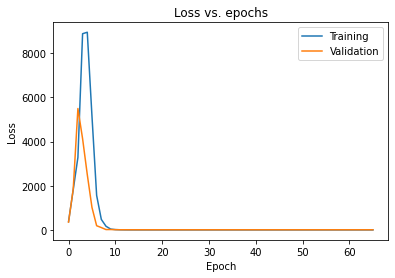

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
class CheckpointCallback(Callback): 
  
  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms11.csv'))
      
    
ckpt_callback11 =CheckpointCallback('/content/drive/My Drive')

In [ ]:
model11 = keras.models.Sequential([
    keras.layers.Dense(100000, input_shape=(1000,), activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model11.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model11.fit(X3_train, y3_train, batch_size= 32, epochs = 1000, validation_data = (X3_val, y3_val), callbacks=[earlystopping3, ckpt_callback11], verbose=False)

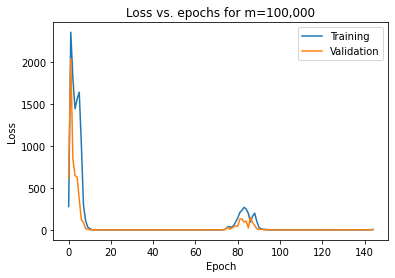

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=100,000')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd1000m10x5')


In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
uploaded = files.upload()

Saving norms11.csv to norms11.csv


In [ ]:
df11 = pd.read_csv('norms11.csv')

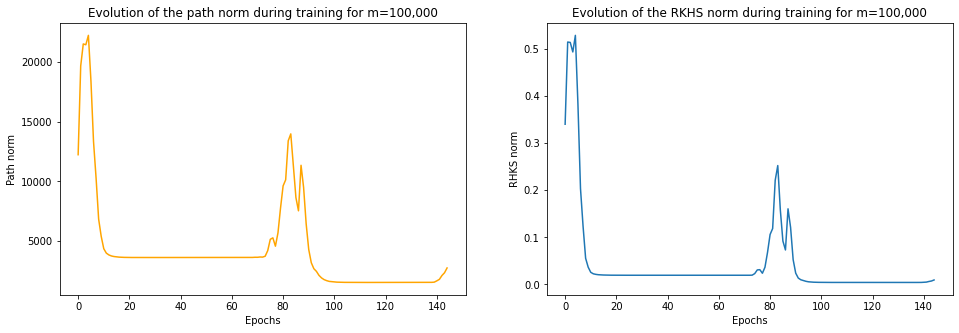

In [ ]:
x = df11['Unnamed: 0']
y1 = df11['path_norms']
y2 = df11['rkhs_norms']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='orange')
axes[0].title.set_text('Evolution of the path norm during training for m=100,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[1].plot(x, y2)
axes[1].title.set_text('Evolution of the RKHS norm during training for m=100,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
fig.savefig('/content/drive/My Drive/ graph_m10x5_d1000.png')

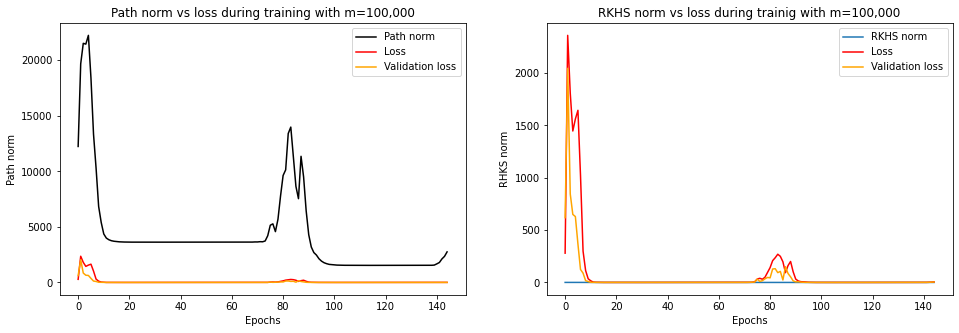

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=100,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=100,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/valloss_m10x5_d1000.png')

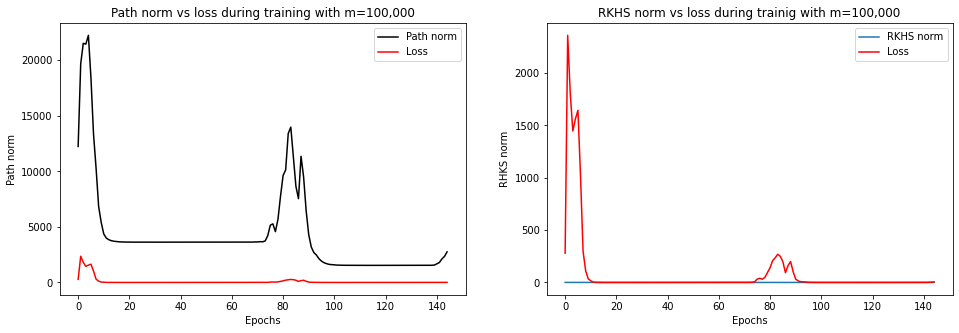

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='black')
axes[0].plot(x, loss, color='red')
#axes[0].plot(x, val_loss, color='orange')
axes[0].title.set_text('Path norm vs loss during training with m=100,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[0].legend(['Path norm', 'Loss', 'Validation loss'])
axes[1].plot(x, y2)
axes[1].plot(x, loss, color='red')
#axes[1].plot(x, val_loss, color='orange')
axes[1].title.set_text('RKHS norm vs loss during trainig with m=100,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
axes[1].legend(['RKHS norm', 'Loss', 'Validation loss'])
fig.savefig('/content/drive/My Drive/loss_m10x5_d1000.png')

#### m = 1,000,000

In [ ]:
model12 = keras.models.Sequential([
    keras.layers.Dense(1000000, activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model12.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
history = model12.fit(X3_train, y3_train, batch_size= 32, epochs = 1000, validation_data = (X3_val, y3_val), callbacks=[earlystopping3], verbose=False)

ResourceExhaustedError: ignored

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=1,000,000')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd1000m10x6')

In [ ]:
class CheckpointCallback(Callback): 
  
  def __init__(self, directory):
    super(CheckpointCallback, self).__init__()
    self.directory = directory
    self.pathnorms = []
    self.rkhsnorms = []

  def on_epoch_end(self, epoch, logs=None):
      pathnorms, rkhsnorms = norms(self.model)
      self.pathnorms.append(pathnorms)
      self.rkhsnorms.append(rkhsnorms)
      
  def on_train_end(self, logs=None):
      d = {'path_norms': self.pathnorms, 'rkhs_norms': self.rkhsnorms}
      df = pd.DataFrame(d)
      df.to_csv(os.path.join(self.directory, 'norms12.csv'))
      
    
ckpt_callback12 =CheckpointCallback('/content/drive/My Drive')

In [ ]:
model12 = keras.models.Sequential([
    keras.layers.Dense(1000000, activation="relu"), 
    keras.layers.Dense(1, activation='linear')
])

In [ ]:
model12.compile(loss='MSE',
                     optimizer=opt,
               metrics = 'accuracy')

In [ ]:
history = model12.fit(X3_train, y3_train, batch_size= 32, epochs = 1000, validation_data = (X3_val, y3_val), callbacks=[earlystopping3, ckpt_callback12], verbose=False)

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs for m=1,000,000')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
fig.savefig('/content/drive/My Drive/lossd1000m10x6')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
uploaded = files.upload()

In [ ]:
df12 = pd.read_csv('norms12.csv')

In [ ]:
x = df12['Unnamed: 0']
y1 = df12['path_norms']
y2 = df12['rkhs_norms']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes[0].plot(x, y1, color='orange')
axes[0].title.set_text('Evolution of the path norm during training for m=1,000,000')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Path norm')
axes[1].plot(x, y2)
axes[1].title.set_text('Evolution of the RKHS norm during training for m=1,000,000')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('RHKS norm')
fig.savefig('/content/drive/My Drive/ graph_m10x6_d1000.png')

In [ ]:
p1, r1 = norms(model)
p2, r2 = norms(model4)
p3, r3 = norms(model5)
p4, r4 = norms(model6)

In [ ]:
from tabulate import tabulate

In [ ]:
data = [[10, p1, r1], [1000, p2, r2], [100000, p3, r3], [1000000,  p4 , r4]]
col = ["Width m, d=10", "Path norm", "RKHS norm"]
print(tabulate(data, headers=col, tablefmt="fancy_grid"))



╒═════════════════╤═════════════╤═════════════╕
│   Width m, d=10 │   Path norm │   RKHS norm │
╞═════════════════╪═════════════╪═════════════╡
│              10 │     2.08819 │   0.0238872 │
├─────────────────┼─────────────┼─────────────┤
│            1000 │    14.6485  │   0.200561  │
├─────────────────┼─────────────┼─────────────┤
│          100000 │    94.5898  │   1.09481   │
├─────────────────┼─────────────┼─────────────┤
│         1000000 │  1041.23    │   8.25313   │
╘═════════════════╧═════════════╧═════════════╛


In [ ]:
p5, r5 = norms(model2)
p6, r6 = norms(model7)
p7, r7 = norms(model8)
p8, r8 = norms(model9)



In [ ]:
data = [[10, p5, r5], [1000, p6, r6], [100000, p7, r7], [1000000, p8, r8]]
col = ["d=100: Width m", "Path norm", "RKHS norm"]
print(tabulate(data, headers=col, tablefmt="fancy_grid"))

╒══════════════════╤═════════════╤═════════════╕
│   d=100: Width m │   Path norm │   RKHS norm │
╞══════════════════╪═════════════╪═════════════╡
│               10 │     1.05037 │ 0.000660863 │
├──────────────────┼─────────────┼─────────────┤
│             1000 │    28.4955  │ 0.00744834  │
├──────────────────┼─────────────┼─────────────┤
│           100000 │   135.143   │ 0.00777777  │
├──────────────────┼─────────────┼─────────────┤
│          1000000 │    49.6039  │ 0.00259333  │
╘══════════════════╧═════════════╧═════════════╛


In [ ]:
p9, r9 = norms(model3)
p10, r10 = norms(model10)
p11, r11 = norms(model11)

In [ ]:
data = [[10, p9, r9], [1000, p10, r10], [100000, p11, r11]]
col = ["d=1000: Width m", "Path norm", "RKHS norm"]
df2 = pd.DataFrame(data, columns=col)


╒═══════════════════╤═════════════╤═════════════╕
│   d=1000: Width m │   Path norm │   RKHS norm │
╞═══════════════════╪═════════════╪═════════════╡
│                10 │     2.13167 │ 2.48512e-05 │
├───────────────────┼─────────────┼─────────────┤
│              1000 │    74.9595  │ 0.000686804 │
├───────────────────┼─────────────┼─────────────┤
│            100000 │  2750.36    │ 0.00934724  │
╘═══════════════════╧═════════════╧═════════════╛


In [ ]:
data = [[10, r1 , kernel_rkhs], [100, r5 ,kernel_rkhs2], [1000,r9 ,kernel_rkhsnorm3]]
col = ["d", "NN RKHS norm", "KRR RKHS norm"]
print(tabulate(data, headers=col, tablefmt="fancy_grid"))

╒══════╤════════════════╤═════════════════╕
│    d │   NN RKHS norm │   KRR RKHS norm │
╞══════╪════════════════╪═════════════════╡
│   10 │    0.0238872   │       19.543    │
├──────┼────────────────┼─────────────────┤
│  100 │    0.000660863 │        1.29457  │
├──────┼────────────────┼─────────────────┤
│ 1000 │    2.48512e-05 │        0.371552 │
╘══════╧════════════════╧═════════════════╛
